This file contains Mobile_Net training and testing process.

In [ ]:
!git clone https://github.com/tensorflow/models.git /content/models


Cloning into '/content/models'...
remote: Enumerating objects: 102339, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 102339 (delta 17), reused 13 (delta 13), pack-reused 102315 (from 2)
Receiving objects: 100% (102339/102339), 642.71 MiB | 15.06 MiB/s, done.
Resolving deltas: 100% (73902/73902), done.


In [ ]:
# Go into research directory
%cd /content/models/research

# Compile protobuf files
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API
!cp object_detection/packages/tf2/setup.py .
!pip install .


/content/models/research
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pymilvus to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tensorflow-model-optimization to determine which version is c

In [ ]:
import object_detection
print("Object Detection API is ready ✅")


Object Detection API is ready ✅


In [ ]:
# 1) Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downgrade protobuf to a compatible version
!pip install protobuf==3.20.*

# Recompile protos again
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires grpcio>=1.71.2, but you have grpcio 1.65.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


/content/models/research


In [ ]:
import tensorflow as tf
import os
from glob import glob
from PIL import Image

# ==== CONFIG ====
DATA_DIR = "/content/drive/MyDrive/total_dataset/dataset_80_10_10"
OUT_DIR = os.path.join(DATA_DIR, "mobilenet/tfrecord")
os.makedirs(OUT_DIR, exist_ok=True)

# YOLO splits
SPLITS = {
    "train": {
        "img": os.path.join(DATA_DIR, "images/train"),
        "lbl": os.path.join(DATA_DIR, "labels/train"),
        "out": os.path.join(OUT_DIR, "train_yolo.record"),
    },
    "val": {
        "img": os.path.join(DATA_DIR, "images/val"),
        "lbl": os.path.join(DATA_DIR, "labels/val"),
        "out": os.path.join(OUT_DIR, "val_yolo.record"),
    },
    "test": {
        "img": os.path.join(DATA_DIR, "images/test"),
        "lbl": os.path.join(DATA_DIR, "labels/test"),
        "out": os.path.join(OUT_DIR, "test_yolo.record"),
    },
}

# Your classes (YOLO: 0=Normal, 1=Cry)
CLASSES = ["Normal", "Cry"]


# ==== TFRecord Helpers ====
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def create_tf_example(img_path, label_path):
    img = Image.open(img_path)
    w, h = img.size

    with tf.io.gfile.GFile(img_path, 'rb') as fid:
        encoded = fid.read()

    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                c, xc, yc, bw, bh = map(float, parts)
                c = int(c)

                # Convert YOLO normalized to normalized TF coordinates
                x_center, y_center = xc * w, yc * h
                box_w, box_h = bw * w, bh * h
                xmin = (x_center - box_w / 2) / w
                xmax = (x_center + box_w / 2) / w
                ymin = (y_center - box_h / 2) / h
                ymax = (y_center + box_h / 2) / h

                # 🔴 No skipping — include all annotations
                xmins.append(xmin)
                xmaxs.append(xmax)
                ymins.append(ymin)
                ymaxs.append(ymax)
                classes_text.append(CLASSES[c].encode("utf8"))
                classes.append(c)  # Keep YOLO IDs (0=Normal, 1=Cry)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        "image/height": int64_list_feature([h]),
        "image/width": int64_list_feature([w]),
        "image/filename": bytes_feature(os.path.basename(img_path).encode("utf8")),
        "image/source_id": bytes_feature(os.path.basename(img_path).encode("utf8")),
        "image/encoded": bytes_feature(encoded),
        "image/format": bytes_feature(b"jpg"),
        "image/object/bbox/xmin": float_list_feature(xmins),
        "image/object/bbox/xmax": float_list_feature(xmaxs),
        "image/object/bbox/ymin": float_list_feature(ymins),
        "image/object/bbox/ymax": float_list_feature(ymaxs),
        "image/object/class/text": tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        "image/object/class/label": int64_list_feature(classes),
    }))
    return tf_example


# ==== Convert all splits ====
for split, cfg in SPLITS.items():
    with tf.io.TFRecordWriter(cfg["out"]) as writer:
        img_files = []
        for ext in ["*.jpg", "*.jpeg", "*.JPG", "*.JPEG", "*.png", "*.PNG"]:
            img_files.extend(glob(os.path.join(cfg["img"], ext)))
        count_images, count_labels = 0, 0
        for img_path in img_files:
            base = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(cfg["lbl"], base + ".txt")
            tf_example = create_tf_example(img_path, label_path)
            writer.write(tf_example.SerializeToString())
            count_images += 1
            if os.path.exists(label_path):
                with open(label_path) as f:
                    count_labels += len(f.readlines())

        print(f"✅ Saved {split} TFRecord → {cfg['out']}")
        print(f"   Images: {count_images}, Labels: {count_labels}")


✅ Saved train TFRecord → /content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/train_yolo.record
   Images: 753, Labels: 753
✅ Saved val TFRecord → /content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/val_yolo.record
   Images: 94, Labels: 94
✅ Saved test TFRecord → /content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/test_yolo.record
   Images: 95, Labels: 95


In [ ]:
# ==== 1. Setup Paths ====
import os

DATA_DIR = "/content/drive/MyDrive/total_dataset/dataset_80_10_10"
PIPELINE_CFG = "/content/mobilenet_pipeline.config"  # we’ll create this below
MODEL_DIR = os.path.join(DATA_DIR, "mobilenet_model")

os.makedirs(MODEL_DIR, exist_ok=True)

# TFRecord files
TRAIN_RECORD = os.path.join(DATA_DIR, "mobilenet/tfrecord/train_yolo.record")
VAL_RECORD   = os.path.join(DATA_DIR, "mobilenet/tfrecord/val_yolo.record")
TEST_RECORD  = os.path.join(DATA_DIR, "mobilenet/tfrecord/test_yolo.record")

# Label map file
LABEL_MAP = os.path.join(DATA_DIR, "mobilenet/label_map.pbtxt")


In [ ]:
label_map_content = """
item {
  id: 1
  name: "Normal"
}
item {
  id: 2
  name: "Cry"
}
"""
with open(LABEL_MAP, "w") as f:
    f.write(label_map_content)

print("✅ Label map written:", LABEL_MAP)


✅ Label map written: /content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/label_map.pbtxt


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz


--2025-09-21 02:33:23--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.207, 108.177.125.207, 142.250.157.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  11.8MB/s    in 1.7s    

2025-09-21 02:33:25 (11.8 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x

In [ ]:
import shutil
shutil.copy(
    "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config",
    PIPELINE_CFG
)
print("✅ Pipeline config ready:", PIPELINE_CFG)


✅ Pipeline config ready: /content/mobilenet_pipeline.config


In [ ]:
import re

# Read pipeline config
with open(PIPELINE_CFG) as f:
    cfg = f.read()

# Replace num_classes
cfg = re.sub(r"num_classes: [0-9]+", "num_classes: 2", cfg)

# Replace fine_tune_checkpoint
cfg = re.sub(r"fine_tune_checkpoint:.*",
             'fine_tune_checkpoint: "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0"',
             cfg)

# Set train TFRecord
cfg = re.sub(r'input_path: ".*tfrecord"',
             f'input_path: "{TRAIN_RECORD}"',
             cfg, count=1)
# Set val TFRecord
cfg = re.sub(r'input_path: ".*tfrecord"',
             f'input_path: "{VAL_RECORD}"',
             cfg, count=1)

# Set label_map
cfg = re.sub(r'label_map_path: ".*"',
             f'label_map_path: "{LABEL_MAP}"',
             cfg)

# Write back
with open(PIPELINE_CFG, "w") as f:
    f.write(cfg)

print("✅ Pipeline config updated")


✅ Pipeline config updated


In [ ]:
!pip install tensorflow-estimator==2.15


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import tensorflow as tf

# ==== CONFIG ====
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Feature description
feature_description = {
    "image/encoded": tf.io.FixedLenFeature([], tf.string),
    "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
    "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
    "image/object/class/label": tf.io.VarLenFeature(tf.int64),
}

def _parse_function(example_proto):
    # Parse features
    features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode image
    image = tf.image.decode_jpeg(features["image/encoded"], channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # Labels → classification (Cry vs Normal)
    labels = tf.sparse.to_dense(features["image/object/class/label"])
    label = tf.reduce_max(labels)   # if multiple boxes, just take one (binary class)

    return image, label

def load_dataset(tfrecord_path, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(500)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


In [ ]:
TRAIN_TFRECORD = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/train_yolo.record"
VAL_TFRECORD   = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/val_yolo.record"
TEST_TFRECORD  = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/test_yolo.record"

train_ds = load_dataset(TRAIN_TFRECORD, shuffle=True)
val_ds   = load_dataset(VAL_TFRECORD, shuffle=False)
test_ds  = load_dataset(TEST_TFRECORD, shuffle=False)

# Check first batch
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels:", labels.numpy())


Images shape: (16, 224, 224, 3)
Labels: [0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0]


Train: 753, Val: 94, Test: 95
Epoch 1/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5172 - loss: 0.7791
Epoch 1: val_loss improved from inf to 0.63111, saving model to /content/drive/MyDrive/total_dataset/mobilenet/model/best_mobilenet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5185 - loss: 0.7782 - val_accuracy: 0.6250 - val_loss: 0.6311
Epoch 2/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5500 - loss: 0.7467
Epoch 2: val_loss improved from 0.63111 to 0.59369, saving model to /content/drive/MyDrive/total_dataset/mobilenet/model/best_mobilenet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - accuracy: 0.5502 - loss: 0.7466 - val_accuracy: 0.6750 - val_loss: 0.5937
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5744 - loss: 0.7140
Epoch 3: val_loss improved from 0.59369 to 0.55959, saving model to /content/drive/MyDrive/total_dataset/mobilenet/model/best_mobilenet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.57

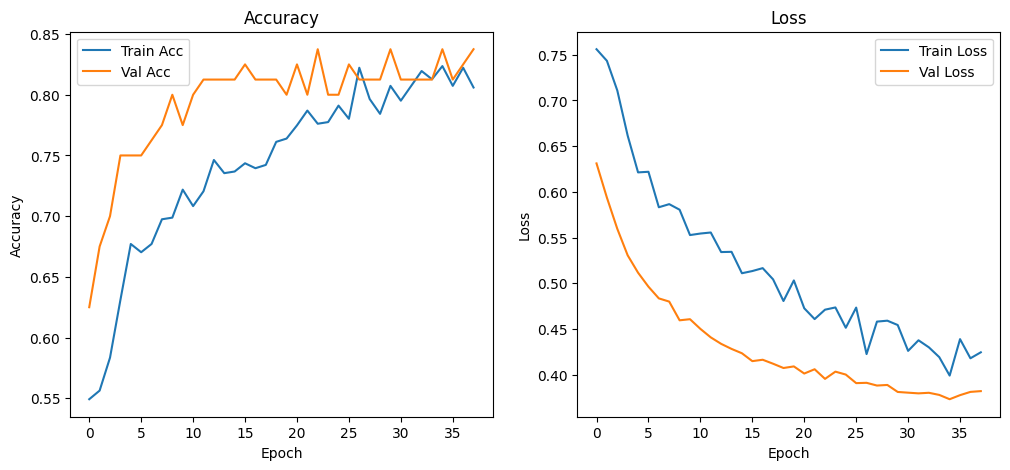

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

# ==== CONFIG ====
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_TFRECORD = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/train_yolo.record"
VAL_TFRECORD   = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/val_yolo.record"
TEST_TFRECORD  = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/mobilenet/tfrecord/test_yolo.record"

MODEL_DIR = "/content/drive/MyDrive/total_dataset/mobilenet/model"
os.makedirs(MODEL_DIR, exist_ok=True)

# ==== TFRecord Parsing ====
feature_description = {
    "image/encoded": tf.io.FixedLenFeature([], tf.string),
    "image/object/class/label": tf.io.VarLenFeature(tf.int64),
}

def _parse_function(example_proto):
    features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode image
    image = tf.image.decode_jpeg(features["image/encoded"], channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # Labels → binary classification (0=Normal, 1=Cry)
    labels = tf.sparse.to_dense(features["image/object/class/label"])
    label = tf.reduce_max(labels)   # if multiple boxes → take one
    return image, label

def load_dataset(tfrecord_path, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(500)
    dataset = dataset.batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
    return dataset

# ==== Count Records ====
def count_tfrecord_records(tfrecord_path):
    return sum(1 for _ in tf.data.TFRecordDataset(tfrecord_path))

train_count = count_tfrecord_records(TRAIN_TFRECORD)
val_count   = count_tfrecord_records(VAL_TFRECORD)
test_count  = count_tfrecord_records(TEST_TFRECORD)

steps_per_epoch = train_count // BATCH_SIZE
validation_steps = val_count // BATCH_SIZE
test_steps = test_count // BATCH_SIZE

print(f"Train: {train_count}, Val: {val_count}, Test: {test_count}")

# ==== Build Model ====
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze for transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ==== Callbacks ====
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, "best_mobilenet.keras"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,  # stop if no improvement for 3 epochs
        restore_best_weights=True,
        verbose=1
    )
]

# ==== Load Data ====
train_ds = load_dataset(TRAIN_TFRECORD, shuffle=True)
val_ds   = load_dataset(VAL_TFRECORD, shuffle=False)
test_ds  = load_dataset(TEST_TFRECORD, shuffle=False)

# ==== Train ====
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ==== Evaluate ====
test_loss, test_acc = model.evaluate(test_ds, steps=test_steps)
print(f"✅ Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# ==== Save final model ====
model.save(os.path.join(MODEL_DIR, "final_mobilenet.keras"))

# ==== Plot Training Curves ====
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
import cv2
import tensorflow as tf
import numpy as np

# Load your trained MobileNet classifier
model = tf.keras.models.load_model("/content/drive/MyDrive/total_dataset/mobilenet/model/best_mobilenet.keras")

# Open video
video_path = "/content/drive/MyDrive/total_dataset/test_original_video/baby_video_1.mp4"
cap = cv2.VideoCapture(video_path)

out_path = "/content/drive/MyDrive/total_dataset/mobilenet/baby_video_out.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

CLASS_NAMES = ["Normal", "Cry"]

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img, verbose=0)[0]
    label = CLASS_NAMES[int(pred[0] < 0.5)] if pred.shape[-1] == 1 else CLASS_NAMES[np.argmax(pred)]
    conf = np.max(pred)

    # Draw label (no boxes yet, since it's classifier)
    cv2.putText(frame, f"{label} ({conf:.2f})", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    out.write(frame)

cap.release()
out.release()
print(f"✅ Saved result video: {out_path}")


✅ Saved result video: /content/drive/MyDrive/total_dataset/mobilenet/baby_video_out.mp4


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 2  # Normal, Cry
IMG_SIZE = 224

def build_mobilenet_detector():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )

    base_model.trainable = False  # freeze backbone initially

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Bounding box regression (4 values per box)
    bbox = layers.Dense(4, activation="sigmoid", name="bbox")(x)

    # Classification (Normal vs Cry)
    cls = layers.Dense(NUM_CLASSES, activation="softmax", name="class")(x)

    model = models.Model(inputs=base_model.input, outputs=[bbox, cls])
    return model

model = build_mobilenet_detector()
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
losses = {
    "bbox": "mse",       # bounding box regression
    "class": "sparse_categorical_crossentropy"
}

loss_weights = {
    "bbox": 1.0,
    "class": 1.0
}

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics={"class": "accuracy"}
)


In [ ]:
import numpy as np
import cv2
import os
from glob import glob

def parse_yolo(img_path, lbl_path, img_size=224):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (img_size, img_size))
    img_resized = img_resized / 255.0

    # default (no object)
    bbox = [0, 0, 0, 0]
    cls = 0

    if os.path.exists(lbl_path):
        with open(lbl_path) as f:
            line = f.readline().strip().split()
            if len(line) == 5:  # use first object
                c, xc, yc, bw, bh = map(float, line)
                xmin = xc - bw/2
                ymin = yc - bh/2
                xmax = xc + bw/2
                ymax = yc + bh/2
                bbox = [xmin, ymin, xmax, ymax]
                cls = int(c)

    return img_resized, (np.array(bbox, dtype=np.float32), cls)

def build_dataset(img_dir, lbl_dir, batch_size=32):
    img_files = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    imgs, bboxes, classes = [], [], []
    for img_path in img_files:
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + ".txt")
        img, (bbox, cls) = parse_yolo(img_path, lbl_path)
        imgs.append(img)
        bboxes.append(bbox)
        classes.append(cls)

    return tf.data.Dataset.from_tensor_slices(
        (np.array(imgs), {"bbox": np.array(bboxes), "class": np.array(classes)})
    ).batch(batch_size).shuffle(1000)


In [ ]:
train_ds = build_dataset(
    "/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/train",
    "/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/train"
)

val_ds = build_dataset(
    "/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/val",
    "/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/val"
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/total_dataset/mobilenet/model/mobilenet_detector.keras",
        save_best_only=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - bbox_loss: 0.0807 - class_accuracy: 0.5207 - class_loss: 0.8757 - loss: 0.9546 - val_bbox_loss: 0.0344 - val_class_accuracy: 0.7126 - val_class_loss: 0.5927 - val_loss: 0.6172
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - bbox_loss: 0.0328 - class_accuracy: 0.7381 - class_loss: 0.5497 - loss: 0.5883 - val_bbox_loss: 0.0303 - val_class_accuracy: 0.7471 - val_class_loss: 0.5072 - val_loss: 0.5335
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - bbox_loss: 0.0275 - class_accuracy: 0.8316 - class_loss: 0.3930 - loss: 0.4444 - val_bbox_loss: 0.0283 - val_class_accuracy: 0.8046 - val_class_loss: 0.4647 - val_loss: 0.4901
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - bbox_loss: 0.0289 - class_accuracy: 0.8417 - class_loss: 0.3957 - loss: 0.4285 - val_bbox_loss: 0.0270 - val_class_accuracy: 0.7931 - val_class_loss: 0.4556 - val_loss: 0.4819
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - bbox_loss: 0.0264 - class_accura

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load trained detector
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/total_dataset/mobilenet/model/mobilenet_detector.keras",
    compile=False
)

CLASS_NAMES = ["Normal", "Cry"]
IMG_SIZE = 224

def run_video_inference(video_path, output_path, model):
    cap = cv2.VideoCapture(video_path)

    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess
        img_in = cv2.resize(frame, (IMG_SIZE, IMG_SIZE)) / 255.0
        img_in = np.expand_dims(img_in, 0)

        # Predict
        pred_bbox, pred_cls = model.predict(img_in, verbose=0)
        pred_bbox = pred_bbox[0]   # [xmin, ymin, xmax, ymax] (normalized)
        pred_cls_id = int(np.argmax(pred_cls[0]))
        pred_conf = float(np.max(pred_cls[0]))

        # Scale back to original size
        xmin, ymin, xmax, ymax = pred_bbox
        xmin, xmax = int(xmin * w), int(xmax * w)
        ymin, ymax = int(ymin * h), int(ymax * h)

        # Draw bounding box + label
        color = (0, 255, 0) if pred_cls_id == 0 else (0, 0, 255)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(frame, f"{CLASS_NAMES[pred_cls_id]} ({pred_conf:.2f})",
                    (xmin, max(20, ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ Saved output video to: {output_path}")

# Example usage
video_in = "/content/drive/MyDrive/total_dataset/test_original_video/baby_video_1.mp4"
video_out = "/content/drive/MyDrive/total_dataset/mobilenet/baby_video_1_result.mp4"
run_video_inference(video_in, video_out, model)


✅ Saved output video to: /content/drive/MyDrive/total_dataset/mobilenet/baby_video_1_result.mp4


In [ ]:
def compute_iou(box1, box2):
    """
    box1, box2 = [xmin, ymin, xmax, ymax] (normalized [0,1])
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    box2_area = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0


In [ ]:
import os

def load_ground_truth(label_path):
    """
    YOLO format: class x_center y_center width height (normalized)
    Returns [xmin, ymin, xmax, ymax], class_id
    """
    if not os.path.exists(label_path):
        return None, None

    with open(label_path) as f:
        line = f.readline().strip().split()
        if len(line) != 5:
            return None, None
        c, xc, yc, bw, bh = map(float, line)
        xmin = xc - bw/2
        ymin = yc - bh/2
        xmax = xc + bw/2
        ymax = yc + bh/2
        return [xmin, ymin, xmax, ymax], int(c)


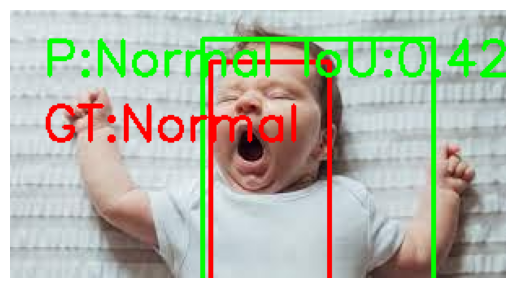

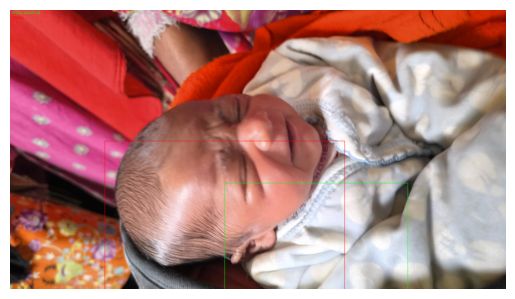

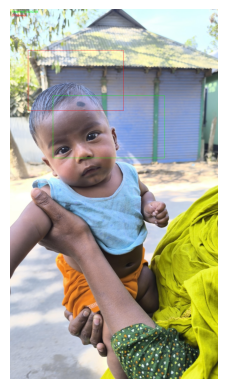

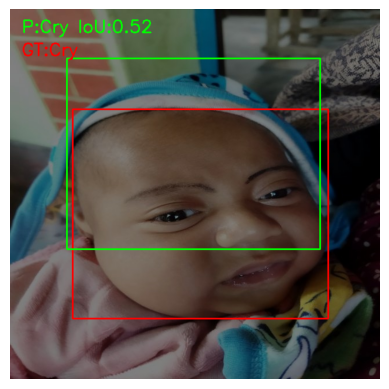

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/total_dataset/mobilenet/model/mobilenet_detector.keras",
    compile=False
)

CLASS_NAMES = ["Normal", "Cry"]
IMG_SIZE = 224

test_img_dir = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test"
test_lbl_dir = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/test"
img_files = glob(os.path.join(test_img_dir, "*.jpg")) + glob(os.path.join(test_img_dir, "*.png"))

ious, y_true, y_pred = [], [], []

for img_path in img_files:
    base = os.path.splitext(os.path.basename(img_path))[0]
    lbl_path = os.path.join(test_lbl_dir, base + ".txt")

    # Load image
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    img_in = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img_in = np.expand_dims(img_in, 0)

    # Prediction
    pred_bbox, pred_cls = model.predict(img_in, verbose=0)
    pred_bbox = pred_bbox[0]
    pred_cls_id = int(np.argmax(pred_cls[0]))

    # Ground truth
    gt_bbox, gt_cls = load_ground_truth(lbl_path)
    if gt_bbox is None:
        continue

    # Compute IoU
    iou = compute_iou(pred_bbox, gt_bbox)
    ious.append(iou)

    # Save labels for classification metrics
    y_true.append(gt_cls)
    y_pred.append(pred_cls_id)

    # Draw GT (blue) + Prediction (red)
    pxmin, pymin, pxmax, pymax = [int(c * w) for c in pred_bbox]
    gxmin, gymin, gxmax, gymax = [int(c * w) for c in gt_bbox]

    cv2.rectangle(img, (gxmin, gymin), (gxmax, gymax), (0, 0, 255), 2)  # GT red
    cv2.rectangle(img, (pxmin, pymin), (pxmax, pymax), (0, 255, 0), 2)  # Pred green
    cv2.putText(img, f"P:{CLASS_NAMES[pred_cls_id]} IoU:{iou:.2f}",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(img, f"GT:{CLASS_NAMES[gt_cls]}",
                (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Show first few examples
    if len(ious) < 5:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix

# ==== CONFIG ====
MODEL_PATH = "/content/drive/MyDrive/total_dataset/mobilenet/model/mobilenet_detector.keras"
TEST_IMG_DIR = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/images/test"
TEST_LBL_DIR = "/content/drive/MyDrive/total_dataset/dataset_80_10_10/labels/test"
OUT_DIR = "/content/drive/MyDrive/total_dataset/mobilenet/test_predictions"
os.makedirs(OUT_DIR, exist_ok=True)

CLASS_NAMES = ["Normal", "Cry"]
IMG_SIZE = 224

# ==== Helpers ====
def compute_iou(box1, box2):
    x1, y1, x2, y2 = max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    box2_area = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
    union = box1_area + box2_area - inter
    return inter / union if union > 0 else 0

def load_ground_truth(label_path):
    if not os.path.exists(label_path): return None, None
    with open(label_path) as f:
        line = f.readline().strip().split()
        if len(line) != 5: return None, None
        c, xc, yc, bw, bh = map(float, line)
        xmin, ymin, xmax, ymax = xc - bw/2, yc - bh/2, xc + bw/2, yc + bh/2
        return [xmin, ymin, xmax, ymax], int(c)

# ==== Load Model ====
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# ==== Evaluation ====
img_files = glob(os.path.join(TEST_IMG_DIR, "*.jpg")) + glob(os.path.join(TEST_IMG_DIR, "*.png"))
ious, y_true, y_pred = [], [], []

for img_path in img_files:
    base = os.path.splitext(os.path.basename(img_path))[0]
    lbl_path = os.path.join(TEST_LBL_DIR, base + ".txt")

    # Load image
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    img_in = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img_in = np.expand_dims(img_in, 0)

    # Prediction
    pred_bbox, pred_cls = model.predict(img_in, verbose=0)
    pred_bbox, pred_cls = pred_bbox[0], pred_cls[0]
    pred_cls_id, pred_conf = int(np.argmax(pred_cls)), float(np.max(pred_cls))

    # Ground truth
    gt_bbox, gt_cls = load_ground_truth(lbl_path)
    if gt_bbox is None: continue

    # IoU
    iou = compute_iou(pred_bbox, gt_bbox)
    ious.append(iou)
    y_true.append(gt_cls)
    y_pred.append(pred_cls_id)

    # Scale boxes
    pxmin, pymin, pxmax, pymax = [int(c * w) for c in pred_bbox]
    gxmin, gymin, gxmax, gymax = [int(c * w) for c in gt_bbox]

    # Draw GT (red) + Prediction (green)
    cv2.rectangle(img, (gxmin, gymin), (gxmax, gymax), (0, 0, 255), 2)
    cv2.putText(img, f"GT: {CLASS_NAMES[gt_cls]}", (gxmin, max(20, gymin - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.rectangle(img, (pxmin, pymin), (pxmax, pymax), (0, 255, 0), 2)
    cv2.putText(img, f"P: {CLASS_NAMES[pred_cls_id]} ({pred_conf:.2f}) IoU:{iou:.2f}",
                (pxmin, max(40, pymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Save result
    out_path = os.path.join(OUT_DIR, base + "_pred.jpg")
    cv2.imwrite(out_path, img)

print(f"✅ Saved predictions with bounding boxes in {OUT_DIR}")

# ==== Metrics ====
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("📊 Average IoU:", np.mean(ious))
print("📊 IoU > 0.5 accuracy:", np.mean([iou >= 0.5 for iou in ious]))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


✅ Saved predictions with bounding boxes in /content/drive/MyDrive/total_dataset/mobilenet/test_predictions
📊 Average IoU: 0.34569672
📊 IoU > 0.5 accuracy: 0.19101123595505617

Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.89      0.86        38
         Cry       0.92      0.86      0.89        51

    accuracy                           0.88        89
   macro avg       0.87      0.88      0.87        89
weighted avg       0.88      0.88      0.88        89


Confusion Matrix:
[[34  4]
 [ 7 44]]
